# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

In [ ]:
import cv2
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

In [ ]:
MODELS_DIR = os.path.join('dataset', 'models')
SCENES_DIR = os.path.join('dataset', 'scenes')

In [ ]:
def natural_sort_key(s):
    return [
        int(text) if text.isdigit() else text.lower()
        for text in re.split(r'(\d+)', s)
    ]

# Generalized Hough Transform with local feature

In [ ]:
class Feature:
    def __init__(self, keypoint, descriptor):
        self.position = keypoint.pt
        self.angle = keypoint.angle
        self.size = keypoint.size
        self.descriptor = descriptor
        self.joining_vector = None

In [ ]:
class Accumulator:
    def __init__(self, image_shape, scale_bins=3, rotation_bins=8, scale_factor=1):
        self.scale_factor = scale_factor
        self.scale_bins = scale_bins
        self.rotation_bins = rotation_bins
        self.accumulator_size = (
            int(image_shape[0] / scale_factor),
            int(image_shape[1] / scale_factor),
            scale_bins,
            rotation_bins, 
        )
        self.accumulator = np.zeros(self.accumulator_size, dtype=np.float32)

    def vote(self, predicted_reference_pixel, scale_idx, rotation_idx):
        x_scaled = predicted_reference_pixel[0] // self.scale_factor
        y_scaled = predicted_reference_pixel[1] // self.scale_factor

        h, w, s_bins, r_bins = self.accumulator_size
        if 0 <= x_scaled < w and 0 <= y_scaled < h and 0 <= scale_idx < s_bins and 0 <= rotation_idx < r_bins:
            self.accumulator[y_scaled, x_scaled, scale_idx, rotation_idx] += 1
        
    def get_peak(self):
        max_idx = np.unravel_index(np.argmax(self.accumulator), self.accumulator.shape)
        peak_x = max_idx[1] * self.scale_factor
        peak_y = max_idx[0] * self.scale_factor
        scale_idx = max_idx[2]
        rotation_idx = max_idx[3]
        return (int(peak_x), int(peak_y), scale_idx, rotation_idx), self.accumulator[max_idx]
    
    def quantize_scale_rotation(self, scale_ratio, rotation_angle):
        scale_idx = int(min(self.scale_bins - 1, max(0, scale_ratio * (self.scale_bins / 2))))
        rotation_idx = int(rotation_angle / (360 / self.rotation_bins)) % self.rotation_bins
        return scale_idx, rotation_idx
    
    def display_accumulator_slice(self, scale_idx, rotation_idx):
        accumulator_slice = self.accumulator[:, :, scale_idx, rotation_idx]
        
        print(f"Displaying slice for scale_idx={scale_idx}, rotation_idx={rotation_idx}")

        h, w = accumulator_slice.shape
        plt.imshow(accumulator_slice, cmap='hot', origin='upper', aspect='auto', extent=[0, w, h, 0])

        plt.colorbar(label="Number of Votes")
        plt.xlabel('Image X Axis (scaled)')
        plt.ylabel('Image Y Axis (scaled)')
        plt.title(f"Accumulator Slice (Scale Idx: {scale_idx}, Rot Idx: {rotation_idx})")
        plt.show()

In [ ]:
class StarModel:
    def __init__(self):
        self.features = []
        self.barycenter = None

    def add_feature(self, feature):
        self.features.append(feature)

    def compute_barycenter(self):
        if not self.features:
            return None
        points = np.array([feature.position for feature in self.features])
        self.barycenter = np.mean(points, axis=0)

    def computing_joining_vector(self):
        if self.barycenter is None:
            return None
        for feature in self.features:
            feature.joining_vector =  self.barycenter - np.array(feature.position)

In [ ]:
class SIFT_GHT_Detector:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.model = None

    def detect_and_compute(self, image):
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        features = [Feature(kp, desc) for kp, desc in zip(keypoints, descriptors)]
        return features
    
    def build_model(self, model_image):
        features = self.detect_and_compute(model_image)
        model = StarModel()
        for feature in features:
            model.add_feature(feature)
        model.compute_barycenter()
        model.computing_joining_vector()
        return model
    
    def match_features(self, model, target_features):
        model_descriptors = np.array([feature.descriptor for feature in model.features])
        target_descriptors = np.array([feature.descriptor for feature in target_features])

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(model_descriptors, target_descriptors, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        return good_matches
    
    def apply_scale_rotation(self, joining_vector, scale, rotation):
        scaled_vector = scale * joining_vector

        angle_rad = np.deg2rad(rotation)
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)], 
                                    [np.sin(angle_rad), np.cos(angle_rad)]])

        rotated_vector = np.dot(rotation_matrix, scaled_vector)
        return rotated_vector
    
    def vote_for_reference_points(self, model, target_features, good_matches, target_image_shape, scale_factor=1):
        accumulator = Accumulator(target_image_shape[:2], scale_factor)

        for match in good_matches:
            model_idx = match.queryIdx
            target_idx = match.trainIdx

            model_feature = model.features[model_idx]
            target_feature = target_features[target_idx]

            scale_ratio = target_feature.size / model_feature.size
            rotation_diff = (target_feature.angle - model_feature.angle) % 360

            scale_idx, rotation_idx = accumulator.quantize_scale_rotation(scale_ratio, rotation_diff) 

            transformed_joining_vector = self.apply_scale_rotation(
                model_feature.joining_vector, scale_ratio, rotation_diff
            )
            predicted_reference_pixel = np.array(target_feature.position) + transformed_joining_vector
            predicted_reference_pixel = np.round(predicted_reference_pixel).astype(np.int32)

            accumulator.vote(predicted_reference_pixel, scale_idx, rotation_idx)

        return accumulator
    
    def calculate_homography(self, model_image, good_matches, model, target_features):
        MIN_MATCH_COUNT = 10
        if len(good_matches) > MIN_MATCH_COUNT:
            src_pts = np.float32([model.features[m.queryIdx].position for m in good_matches]).reshape(-1,2)
            dst_pts = np.float32([target_features[m.trainIdx].position for m in good_matches]).reshape(-1,2)

            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w = model_image.shape[:2]
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)
            return np.int32(dst)
        else:
            print("Not enough matches are found - %d/%d" % (len(good_matches), MIN_MATCH_COUNT))
            return None

    def detect(self, model_image, target_image):
        model = self.build_model(model_image)
        target_features = self.detect_and_compute(target_image)
        good_matches = self.match_features(model, target_features)
        
        accumulator = self.vote_for_reference_points(model, target_features, good_matches, target_image.shape)
        max_loc, _ = accumulator.get_peak()

        bounding_box = self.calculate_homography(model_image, good_matches, model, target_features)

        return max_loc, accumulator, bounding_box

In [ ]:
models = {}
model_files = sorted(os.listdir(MODELS_DIR), key=natural_sort_key)
for i, model_filename in enumerate(model_files):
    if model_filename.endswith(('.png', '.jpg', '.jpeg')):
        book_name = f"Book {i}"
        model_path = os.path.join(MODELS_DIR, model_filename)
        models[book_name] = cv2.imread(model_path)
        if models[book_name] is None:
            print(f"Error loading model: {model_path}")

In [ ]:
scenes = {}
scene_files = sorted(os.listdir(SCENES_DIR), key=natural_sort_key)
for scene_filename in scene_files:
    if scene_filename.endswith(('.png', '.jpg', '.jpeg')):
        scene_path = os.path.join(SCENES_DIR, scene_filename)
        scenes[scene_filename] = cv2.imread(scene_path)
        if scenes[scene_filename] is None:
            print(f"Error loading scene: {scene_path}")

In [ ]:
model_image = models['Book 12']
target_image = scenes['scene_17.jpg']

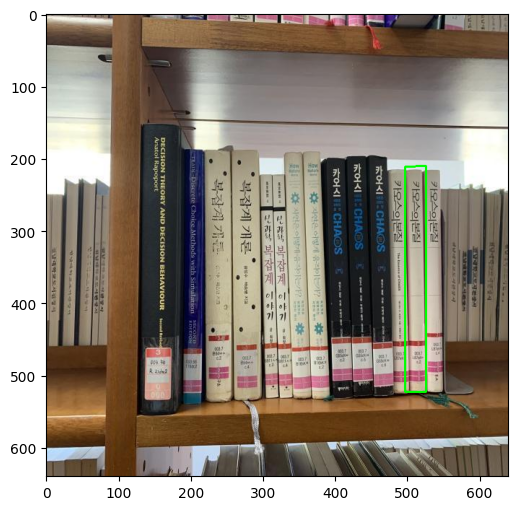

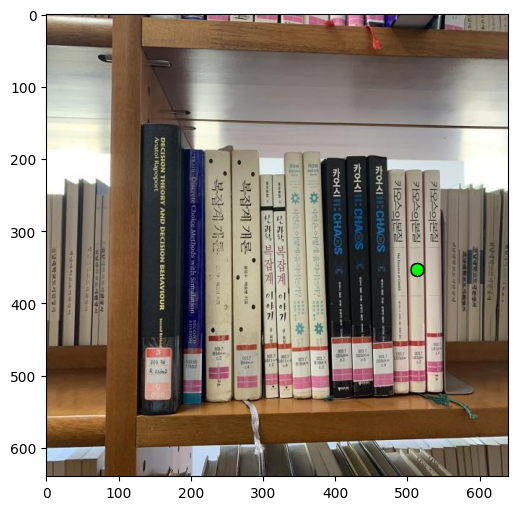

In [ ]:
detector = SIFT_GHT_Detector()

overlay_image = target_image.copy()
target_image_with_detection_point = target_image.copy()

detection_point, accumulator, bounding_box = detector.detect(model_image, target_image)

scale, rotation = detection_point[2:]
detection_point = detection_point[:2]

cv2.polylines(overlay_image, [bounding_box], isClosed=True, color=(0, 255, 0), thickness=2)
cv2.circle(target_image_with_detection_point, detection_point, radius=10, color=(0, 0, 0), thickness=-1)
cv2.circle(target_image_with_detection_point, detection_point, radius=8, color=(0, 255, 0), thickness=-1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(target_image_with_detection_point, cv2.COLOR_BGR2RGB))
plt.show()